In [1]:
import tensorflow as tf
from pathlib import Path
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
fdata = f'../../data/sars-cov2-ct-scan'

p = Path(fdata)
ptrain = p / 'train'
ptest = p / 'test'
pval = p / 'val'

In [4]:
BATCH_SIZE = 10

w, h = (224, 224)

train_generator = ImageDataGenerator()

val_generator = ImageDataGenerator()

test_generator = ImageDataGenerator()

# train_generator = ImageDataGenerator(rescale=1. / 255)

# val_generator = ImageDataGenerator(rescale=1. / 255)

# test_generator = ImageDataGenerator(rescale=1. / 255)

In [5]:
traingen = train_generator.flow_from_directory(ptrain,
                                               target_size=(w, h),
                                               class_mode='binary',
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True,
                                               seed=42)

validgen = val_generator.flow_from_directory(pval,
                                               target_size=(w, h),
                                               class_mode='binary',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

testgen = test_generator.flow_from_directory(ptest,
                                             target_size=(w, h),
                                             class_mode='binary',
                                             batch_size=1,
                                             shuffle=False,
                                             seed=42)

Found 1788 images belonging to 2 classes.
Found 198 images belonging to 2 classes.
Found 495 images belonging to 2 classes.


In [6]:
traingen.classes

array([0, 0, 0, ..., 1, 1, 1])

In [7]:
traingen.batch_index

0

In [8]:
base_model = keras.applications.VGG16(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(w, h, 3),
    include_top=True)

In [9]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [10]:
#Freeze the base model
base_model.trainable = True
for layer in base_model.layers:
    layer.trainable = False

In [11]:
for layer in base_model.layers:
    print(layer.trainable)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


In [12]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [14]:
inputs = keras.Input(shape=(w, h, 3))
x = base_model(inputs)
x = keras.layers.Flatten()(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(1000)(x)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.Dense(500)(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(100)(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(20)(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(10)(x)
x = keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(1, activation='sigmoid')(x)
'''
activation = ‘softmax’ should be used for multiclass classification whereas ’sigmoid’ for binary classification.

https://dataaspirant.com/difference-between-softmax-function-and-sigmoid-function/

'''
model = keras.Model(inputs, outputs)

In [15]:
from cosine_annealing import CosineAnnealingScheduler
epochs = 20
calr = CosineAnnealingScheduler(T_max=epochs, eta_max=0.05, eta_min=4e-4)

In [16]:
foldername = f'models/VGG16d'
save_model = tf.keras.callbacks.ModelCheckpoint(
    filepath=foldername+'/tl-model_{epoch:02d}.h5')

save_weight = tf.keras.callbacks.ModelCheckpoint(
    filepath=foldername+'/tl-weight_{epoch:02d}.h5',
    save_weights_only=True)

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)

model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.Hinge(),
              metrics=[keras.metrics.BinaryAccuracy()])
history = model.fit(traingen, epochs=epochs, validation_data= validgen,
             callbacks=[save_model, save_weight])

Epoch 1/20
179/179 [==============================] - 34s 162ms/step - loss: 0.8766 - binary_accuracy: 0.6270 - val_loss: 0.9333 - val_binary_accuracy: 0.5707
Epoch 2/20
179/179 [==============================] - 29s 162ms/step - loss: 0.8378 - binary_accuracy: 0.6689 - val_loss: 1.0101 - val_binary_accuracy: 0.4949
Epoch 3/20
179/179 [==============================] - 31s 175ms/step - loss: 0.9359 - binary_accuracy: 0.5682 - val_loss: 0.9337 - val_binary_accuracy: 0.5758
Epoch 4/20
179/179 [==============================] - 27s 151ms/step - loss: 0.9066 - binary_accuracy: 0.5979 - val_loss: 1.0051 - val_binary_accuracy: 0.5000
Epoch 5/20
179/179 [==============================] - 27s 150ms/step - loss: 0.8966 - binary_accuracy: 0.6079 - val_loss: 1.0051 - val_binary_accuracy: 0.5000
Epoch 6/20
179/179 [==============================] - 26s 143ms/step - loss: 0.8510 - binary_accuracy: 0.6532 - val_loss: 1.0000 - val_binary_accuracy: 0.5051
Epoch 7/20
179/179 [==========================

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


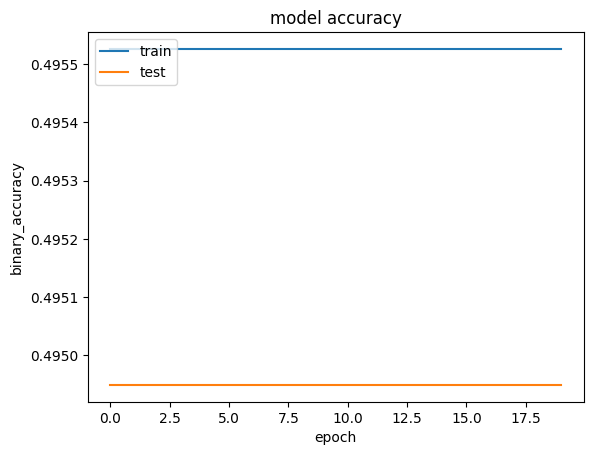

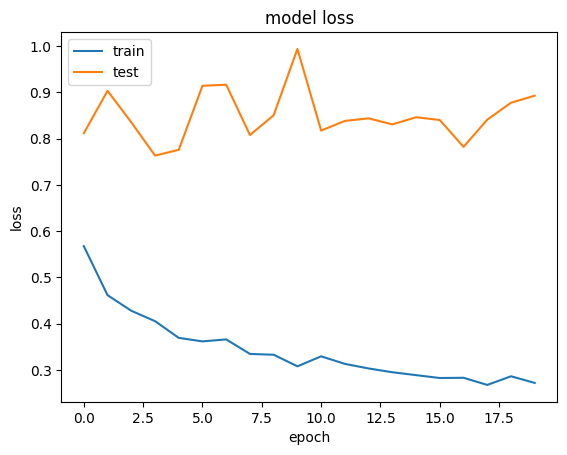

In [ ]:
# list all data in history
print(history.history.keys())

import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('binary_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
yp=base_model.predict_generator(testgen)
print(yp.shape)

C:\Users\ankan\AppData\Local\Temp\ipykernel_10592\3774926068.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  yp=base_model.predict_generator(testgen)


(495, 7, 7, 512)


In [ ]:
len(testgen.classes)

495

In [ ]:
testgen.class_indices

{'COVID': 0, 'non-COVID': 1}

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

num_of_test_samples = len(testgen.classes)
batch_size = 1
Y_pred = model.predict_generator(testgen, num_of_test_samples // batch_size)
y_pred = [round(i[0]) for i in Y_pred]
print('Confusion Matrix')
print(confusion_matrix(testgen.classes, y_pred))
print('Classification Report')
target_names = ['COVID', 'Non-COVID']
print(classification_report(testgen.classes, y_pred, target_names=target_names))

C:\Users\ankan\AppData\Local\Temp\ipykernel_12832\2839527870.py:6: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(testgen, num_of_test_samples // batch_size)


Confusion Matrix
[[126 124]
 [ 11 234]]
Classification Report
              precision    recall  f1-score   support

       COVID       0.92      0.50      0.65       250
   Non-COVID       0.65      0.96      0.78       245

    accuracy                           0.73       495
   macro avg       0.79      0.73      0.71       495
weighted avg       0.79      0.73      0.71       495



In [ ]:
testgen.image_shape

(224, 224, 3)

In [ ]:
testgen.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
yp=model.predict_generator(testgen, len(testgen.classes))

C:\Users\ankan\AppData\Local\Temp\ipykernel_10592\3400265095.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  yp=model.predict_generator(testgen, len(testgen.classes))


In [ ]:
yp.shape

(495, 1)

In [ ]:
import math
len([round(i[0]) for i in yp])

495

In [ ]:
len(testgen.classes)

495